In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
mpl.rcParams['figure.dpi'] = 300
plt.style.use('ggplot')

1 Physical GPUs, 1 Logical GPUs


# Digit classification

In [2]:
def get_models_history(histories):
    fig, axs = plt.subplots(1, 2, figsize=(14,5))
    colors_graph = [
    "#927ced",
    "#73bd4d",
    "#e462c0",
    "#eb5e52"]
    handles = []
    for (model_name, history), color in zip(histories.items(), colors_graph):
        axs[0].plot(history.history['loss'], c=color, ls='-.', alpha=.7, marker='o', ms=3)
        axs[0].plot(history.history['val_loss'], label=model_name, c=color, marker='o', ms=3)
        axs[1].plot(history.history['accuracy'], c=color, ls='-.', alpha=.7, marker='o', ms=3)
        axs[1].plot(history.history['val_accuracy'], label=model_name, c=color, marker='o', ms=3)
        handles.append(mpatches.Patch(color=color, label=model_name))
    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[0].set_ylabel('loss')
    axs[1].set_ylabel('accuracy')
    handles.append(Line2D([0], [0], color='grey', lw=1, ls='-', label='validation'))
    handles.append(Line2D([0], [0], color='grey', lw=1, ls='-.', label='training'))
    fig.subplots_adjust(right=0.85)
    fig.legend(handles=handles,
        loc="center right",
        borderaxespad=1)
    return fig

## Import data

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data() # Load data

x_train_expand = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test_expand = x_test.reshape((x_test.shape[0], 28, 28, 1))

x_train_expand = x_train_expand.astype('float16')
x_test_expand = x_test_expand.astype('float16')

x_train_normalize = x_train_expand/(2**8-1)
x_test_normalize = x_test_expand/(2**8-1)

num_class = len(np.unique(y_train)) #10
input_shape = x_train_expand.shape[1:4] #(28,28,1)
y_train = tf.keras.utils.to_categorical(y_train, num_class)
y_test = tf.keras.utils.to_categorical(y_test, num_class)

print('Shape of x_train: '+str(x_train_expand.shape))
print('Shape of y_train: '+str(y_train.shape))

Shape of x_train: (60000, 28, 28, 1)
Shape of y_train: (60000, 10)


## Build model

In [4]:
training_histories = {}
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(filters=8, kernel_size=(5, 5), strides=1, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=1, activation="relu", padding="same"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=32, activation="relu"),
        tf.keras.layers.Dense(units=num_class, activation="softmax"),
    ], name="SimpleCNN"
)
model.summary()
model_init = model.get_weights()

val_split = 0.3

Model: "SimpleCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                100384    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 102,090
Trainable params: 102,090
Non-trainable params: 0
___________________________________________________

## Training

In [5]:
ep = 5 # number of epochs
model.set_weights(model_init)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
training_histories["lr:.001"] = model.fit(x=x_train_expand, y=y_train, validation_split=val_split, epochs=ep, shuffle=True)

test_loss, test_acc = model.evaluate(x=x_test_expand, y=y_test)
print('\nTest accuracy:', test_acc)

Epoch 1/5
1313/1313 [==============================] - 5s 4ms/step - loss: 0.4984 - accuracy: 0.9013 - val_loss: 0.1267 - val_accuracy: 0.9641
Epoch 2/5
1313/1313 [==============================] - 5s 4ms/step - loss: 0.0934 - accuracy: 0.9727 - val_loss: 0.0895 - val_accuracy: 0.9743
Epoch 3/5
1313/1313 [==============================] - 5s 4ms/step - loss: 0.0620 - accuracy: 0.9811 - val_loss: 0.0905 - val_accuracy: 0.9740
Epoch 4/5
1313/1313 [==============================] - 5s 4ms/step - loss: 0.0471 - accuracy: 0.9851 - val_loss: 0.0888 - val_accuracy: 0.9758
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.0651 - accuracy: 0.9819

Test accuracy: 0.9818999767303467


In [6]:
ep = 5 # number of epochs
model.set_weights(model_init)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
training_histories["lr:.001 - Normalized"] = model.fit(x=x_train_normalize, y=y_train, validation_split=val_split, epochs=ep, shuffle=True)

test_loss, test_acc = model.evaluate(x=x_test_expand, y=y_test)
print('\nTest accuracy:', test_acc)

Epoch 1/5
1313/1313 [==============================] - 5s 4ms/step - loss: 0.2201 - accuracy: 0.9340 - val_loss: 0.0965 - val_accuracy: 0.9713
Epoch 2/5
1313/1313 [==============================] - 5s 4ms/step - loss: 0.0745 - accuracy: 0.9767 - val_loss: 0.0758 - val_accuracy: 0.9792
Epoch 3/5
1313/1313 [==============================] - 5s 4ms/step - loss: 0.0513 - accuracy: 0.9840 - val_loss: 0.0713 - val_accuracy: 0.9799
Epoch 4/5
1313/1313 [==============================] - 5s 4ms/step - loss: 0.0391 - accuracy: 0.9878 - val_loss: 0.0567 - val_accuracy: 0.9829
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 8.9657 - accuracy: 0.9864

Test accuracy: 0.9864000082015991


In [7]:
ep = 10 # number of epochs
model.set_weights(model_init)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1.0), metrics=["accuracy"])
training_histories["lr:1.0 - Normalized"] = model.fit(x=x_train_normalize, y=y_train, validation_split=val_split, epochs=ep, shuffle=True)

test_loss, test_acc = model.evaluate(x=x_test_expand, y=y_test)
print('\nTest accuracy:', test_acc)

Epoch 1/10
1313/1313 [==============================] - 5s 4ms/step - loss: 165.1429 - accuracy: 0.1017 - val_loss: 2.4169 - val_accuracy: 0.0989
Epoch 2/10
1313/1313 [==============================] - 5s 4ms/step - loss: 2.4016 - accuracy: 0.1012 - val_loss: 2.4055 - val_accuracy: 0.0966
Epoch 3/10
1313/1313 [==============================] - 5s 3ms/step - loss: 2.4040 - accuracy: 0.1008 - val_loss: 2.4484 - val_accuracy: 0.0966
Epoch 4/10
1313/1313 [==============================] - 5s 4ms/step - loss: 2.4116 - accuracy: 0.1008 - val_loss: 2.3402 - val_accuracy: 0.1079
Epoch 5/10
1313/1313 [==============================] - 5s 3ms/step - loss: 2.4164 - accuracy: 0.0993 - val_loss: 2.4358 - val_accuracy: 0.1035
Epoch 6/10
1313/1313 [==============================] - 5s 3ms/step - loss: 2.4092 - accuracy: 0.1028 - val_loss: 2.3790 - val_accuracy: 0.1079
Epoch 7/10
1313/1313 [==============================] - 5s 3ms/step - loss: 2.4139 - accuracy: 0.1020 - val_loss: 2.3781 - val_accurac

In [8]:
ep = 10 # number of epochs
model.set_weights(model_init)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1.0e-7), metrics=["accuracy"])
training_histories["lr:1e-7 - Normalized"] = model.fit(x=x_train_normalize, y=y_train, validation_split=val_split, epochs=ep, shuffle=True)

test_loss, test_acc = model.evaluate(x=x_test_expand, y=y_test)
print('\nTest accuracy:', test_acc)

Epoch 1/10
1313/1313 [==============================] - 5s 4ms/step - loss: 2.3048 - accuracy: 0.1349 - val_loss: 2.3053 - val_accuracy: 0.1313
Epoch 2/10
1313/1313 [==============================] - 5s 4ms/step - loss: 2.3019 - accuracy: 0.1439 - val_loss: 2.3023 - val_accuracy: 0.1399
Epoch 3/10
1313/1313 [==============================] - 5s 4ms/step - loss: 2.2989 - accuracy: 0.1525 - val_loss: 2.2992 - val_accuracy: 0.1485
Epoch 4/10
1313/1313 [==============================] - 5s 4ms/step - loss: 2.2958 - accuracy: 0.1610 - val_loss: 2.2961 - val_accuracy: 0.1563
Epoch 5/10
1313/1313 [==============================] - 5s 4ms/step - loss: 2.2926 - accuracy: 0.1692 - val_loss: 2.2929 - val_accuracy: 0.1652
Epoch 6/10
1313/1313 [==============================] - 5s 3ms/step - loss: 2.2894 - accuracy: 0.1775 - val_loss: 2.2897 - val_accuracy: 0.1726
Epoch 7/10
1313/1313 [==============================] - 5s 4ms/step - loss: 2.2862 - accuracy: 0.1849 - val_loss: 2.2864 - val_accuracy:

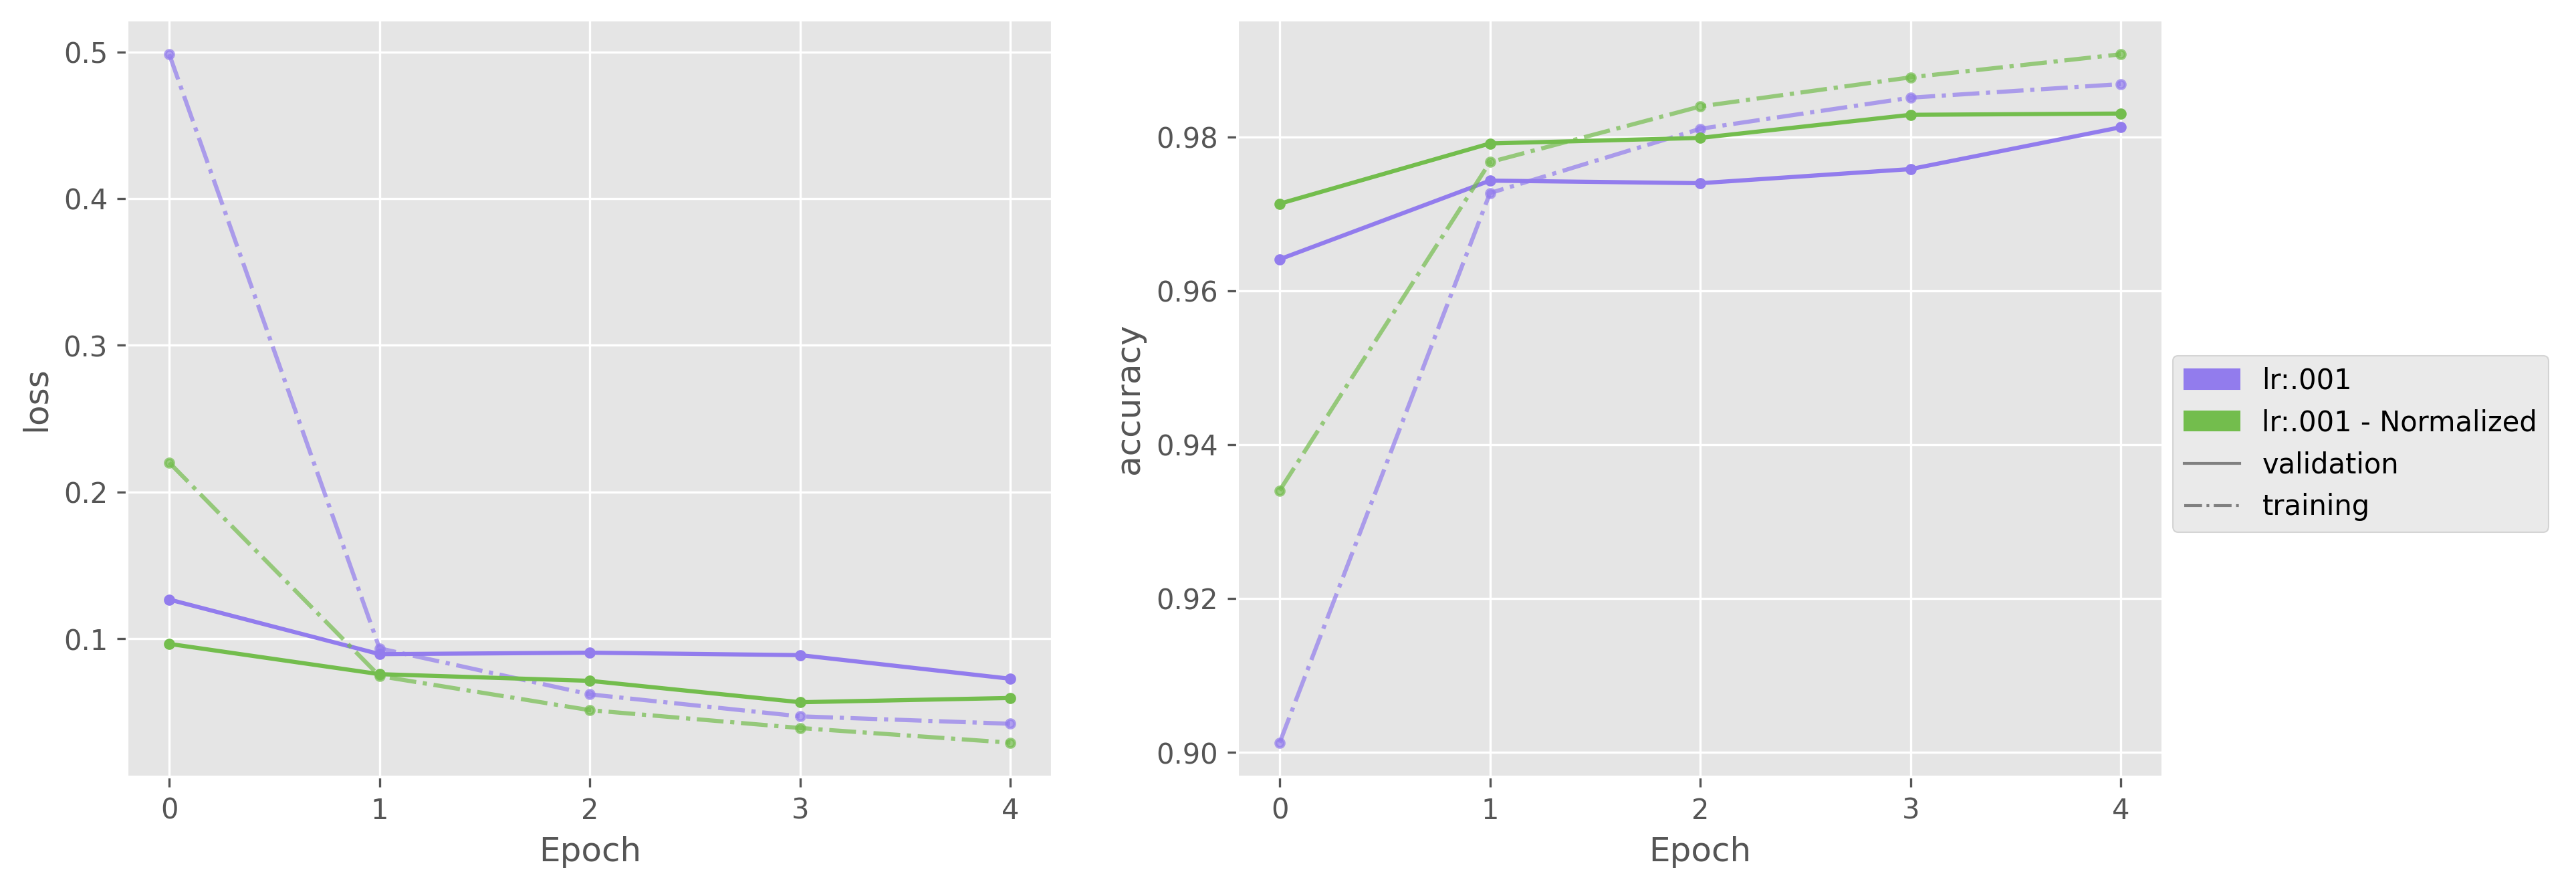

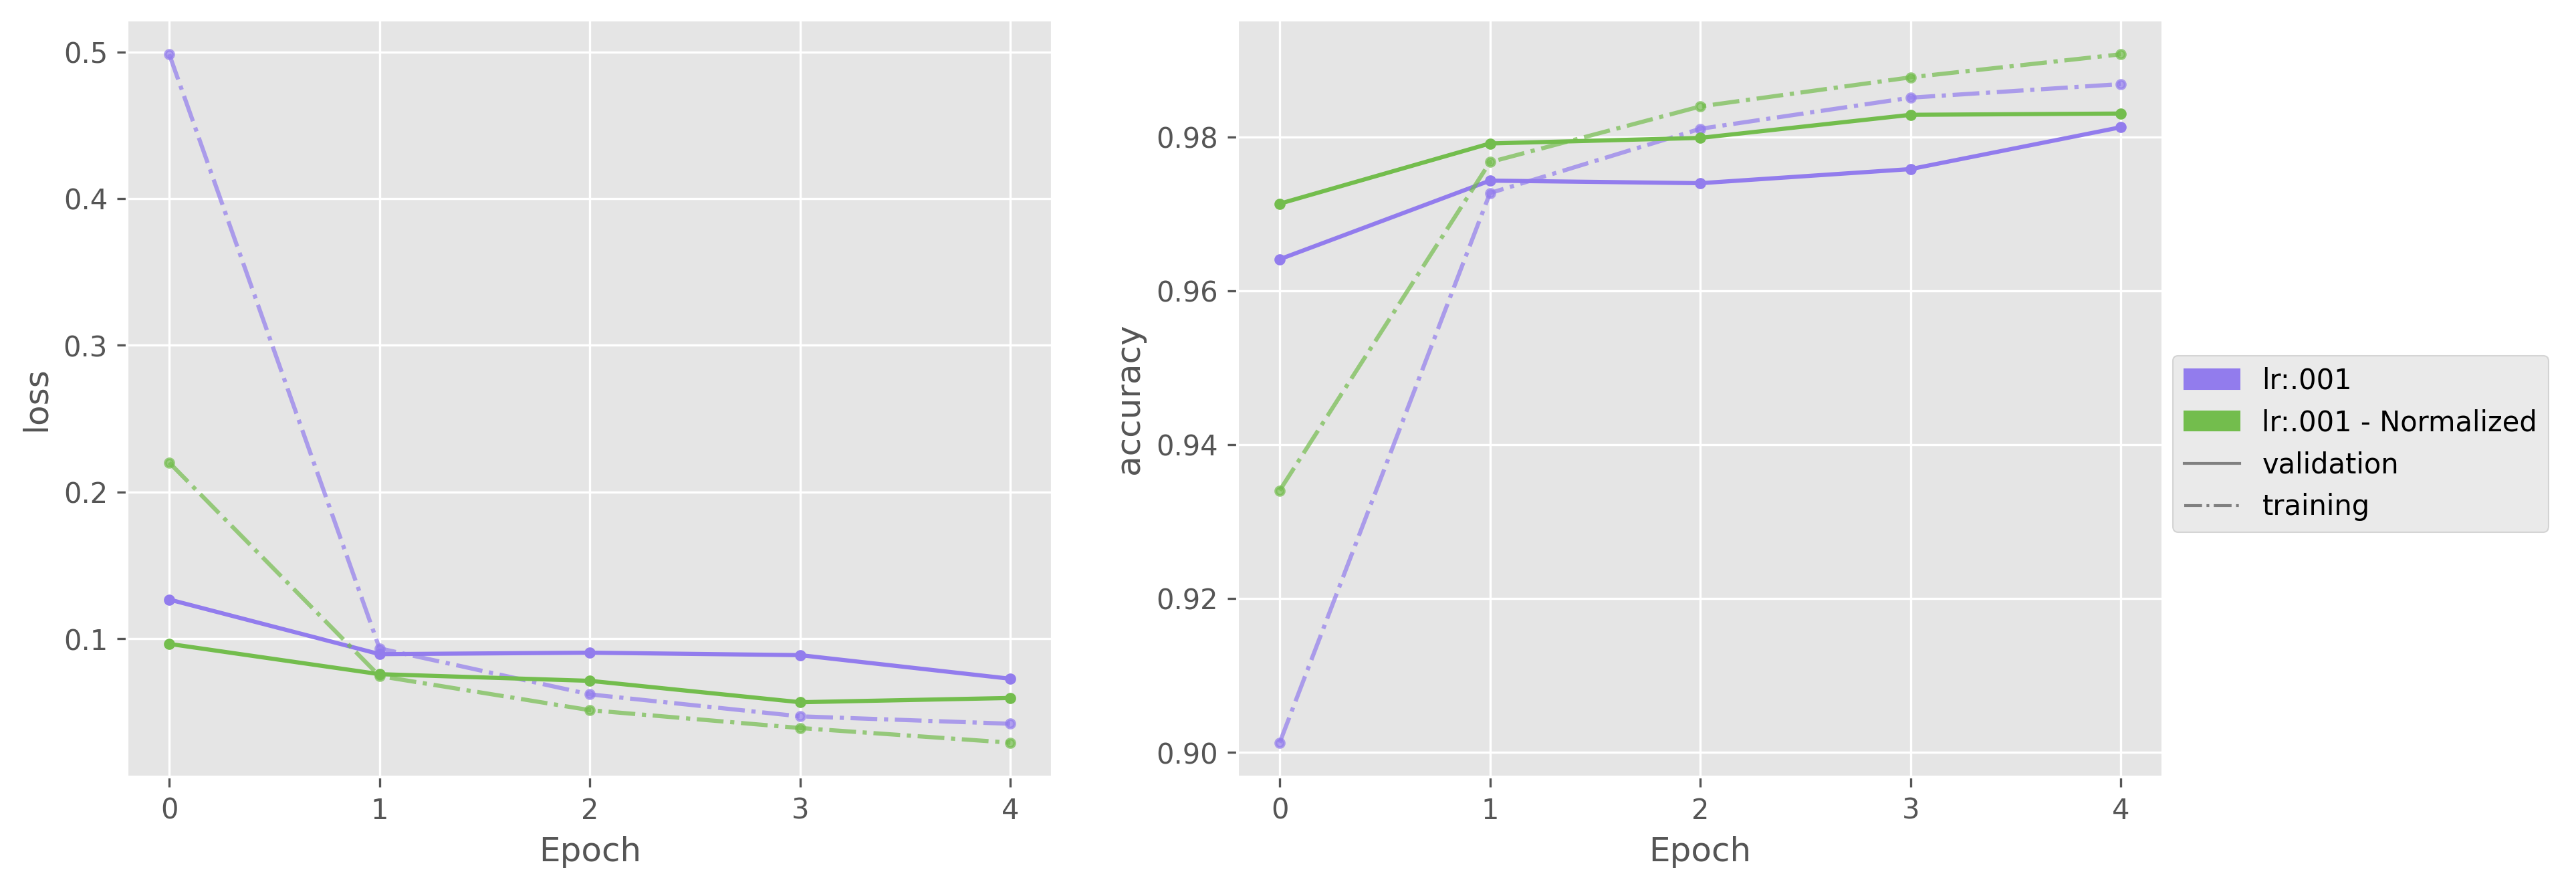

In [7]:
get_models_history(training_histories)

# Semantic segmentation

In [8]:
def get_models_history_(history):
    fig, axs = plt.subplots(1, 2, figsize=(14,5))
    color = "#927ced"
    axs[0].plot(history.history['loss'], c=color, ls='-.', marker='o', ms=3, alpha=.7)
    axs[0].plot(history.history['val_loss'], c=color, marker='o', ms=3)
    axs[1].plot(history.history['accuracy'], c=color, ls='-.', marker='o', ms=3, alpha=.7)
    axs[1].plot(history.history['val_accuracy'], c=color, marker='o', ms=3)
    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[0].set_ylabel('loss')
    axs[1].set_ylabel('accuracy')
    handles = []
    handles.append(Line2D([0], [0], color='grey', lw=1, ls='-', label='validation'))
    handles.append(Line2D([0], [0], color='grey', lw=1, ls='-.', label='training'))
    fig.subplots_adjust(right=0.85)
    fig.legend(handles=handles,
        loc="center right",
        borderaxespad=1)
    return fig

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

## Import data

In [9]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

@tf.function
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

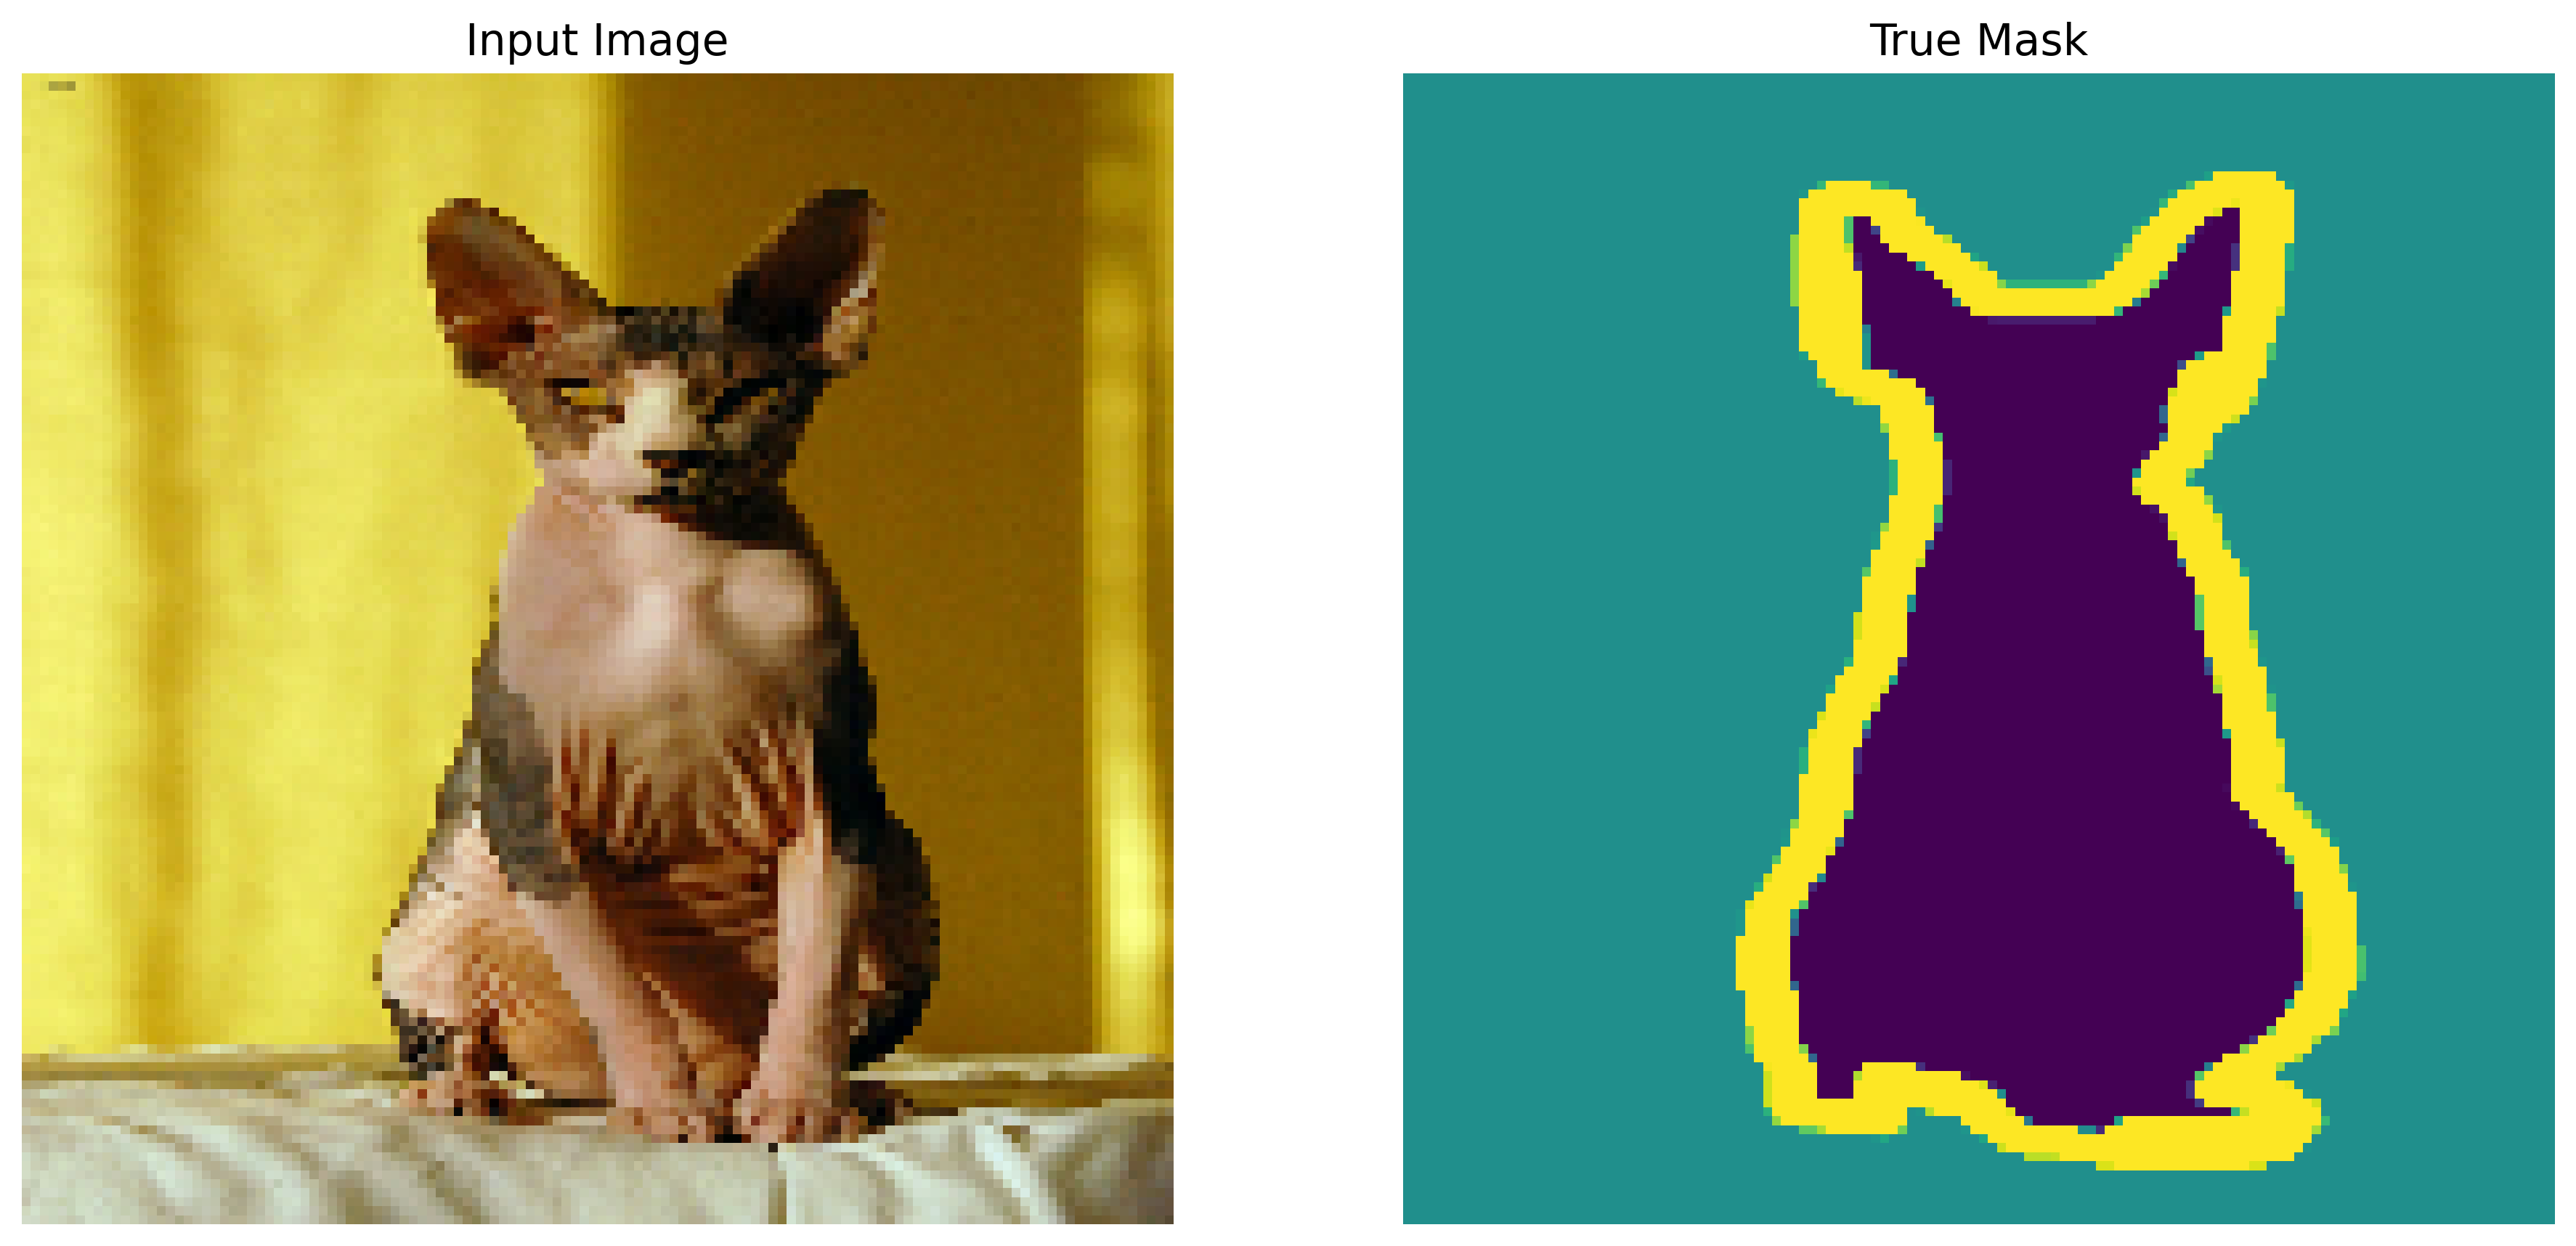

In [10]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

for image, mask in train.take(5):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Build model

### Basic model

In [11]:
basic_model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(128,128,3)),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=2, activation="relu", padding="same"),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, activation="relu", padding="same"),
        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation="relu", padding="same"),
        tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, padding="same")
    ]
)
basic_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 128, 3)       1731      
Total params: 62,243
Trainable params: 62,243
Non-trainable params: 0
____________________________________________________

### Custom U-Net

In [7]:
encoder_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
encoder_model_outputs = [encoder_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
encoder_stack = tf.keras.Model(inputs=encoder_model.input, outputs=encoder_model_outputs)

encoder_stack.trainable = False

decoder_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


inputs = tf.keras.layers.Input(shape=[128, 128, 3])
# Downsampling through the model
skips = encoder_stack(inputs)
x = skips[-1]
skips = reversed(skips[:-1])

# Upsampling and establishing the skip connections
for up, skip in zip(decoder_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

# This is the last layer of the model
last = tf.keras.layers.Conv2DTranspose(
  3, 3, strides=2,
  padding='same')  #64x64 -> 128x128

x = last(x)

UNet_model = tf.keras.Model(inputs=inputs, outputs=x)
UNet_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       [(None, 64, 64, 96), 1841984     input_3[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 8, 8, 512)    1476608     functional_1[0][4]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential_1[0][0]               
                                                                 functional_1[0][3]    

## Train

In [12]:
training_histories = {}

In [13]:
EPOCHS = 5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

basic_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
training_histories['Basic model'] = basic_model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Epoch 1/5
115/115 [==============================] - 3s 29ms/step - loss: 0.8999 - accuracy: 0.5791 - val_loss: 0.8319 - val_accuracy: 0.5815
Epoch 2/5
115/115 [==============================] - 3s 24ms/step - loss: 0.7944 - accuracy: 0.6209 - val_loss: 0.7918 - val_accuracy: 0.6383
Epoch 3/5
115/115 [==============================] - 3s 24ms/step - loss: 0.7455 - accuracy: 0.6585 - val_loss: 0.7275 - val_accuracy: 0.6699
Epoch 4/5
115/115 [==============================] - 3s 24ms/step - loss: 0.7023 - accuracy: 0.6825 - val_loss: 0.7058 - val_accuracy: 0.6823
Epoch 5/5
115/115 [==============================] - 3s 24ms/step - loss: 0.6789 - accuracy: 0.6949 - val_loss: 0.6734 - val_accuracy: 0.7018


In [10]:
UNet_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
training_histories['Custom U-Net'] = UNet_model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Epoch 1/5
115/115 [==============================] - 8s 72ms/step - loss: 0.4161 - accuracy: 0.8286 - val_loss: 0.3232 - val_accuracy: 0.8745
Epoch 2/5
115/115 [==============================] - 7s 65ms/step - loss: 0.2839 - accuracy: 0.8825 - val_loss: 0.2900 - val_accuracy: 0.8835
Epoch 3/5
115/115 [==============================] - 8s 65ms/step - loss: 0.2664 - accuracy: 0.8885 - val_loss: 0.2845 - val_accuracy: 0.8861
Epoch 4/5
115/115 [==============================] - 7s 65ms/step - loss: 0.2537 - accuracy: 0.8930 - val_loss: 0.2842 - val_accuracy: 0.8889
Epoch 5/5
115/115 [==============================] - 8s 65ms/step - loss: 0.2440 - accuracy: 0.8966 - val_loss: 0.2744 - val_accuracy: 0.8892


## Evaluate

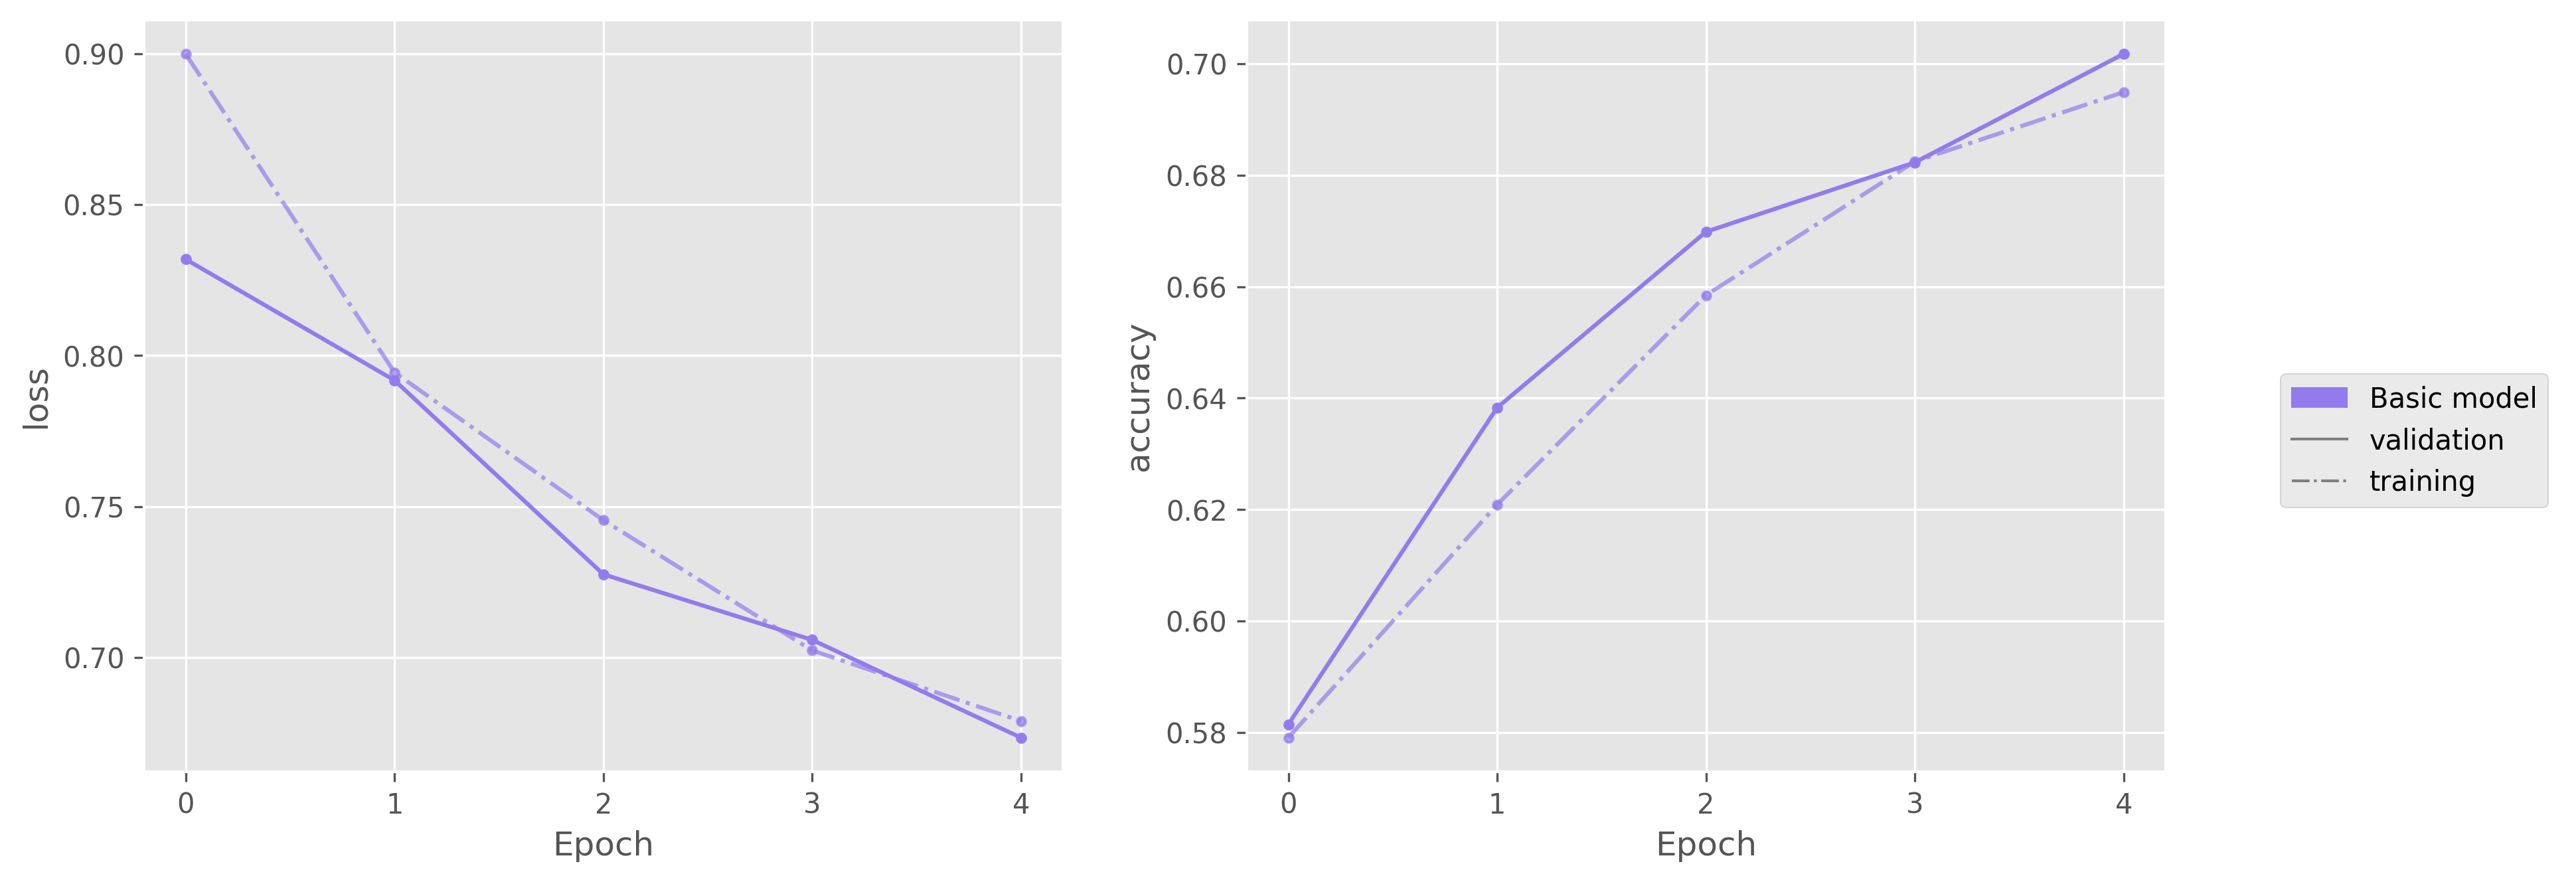

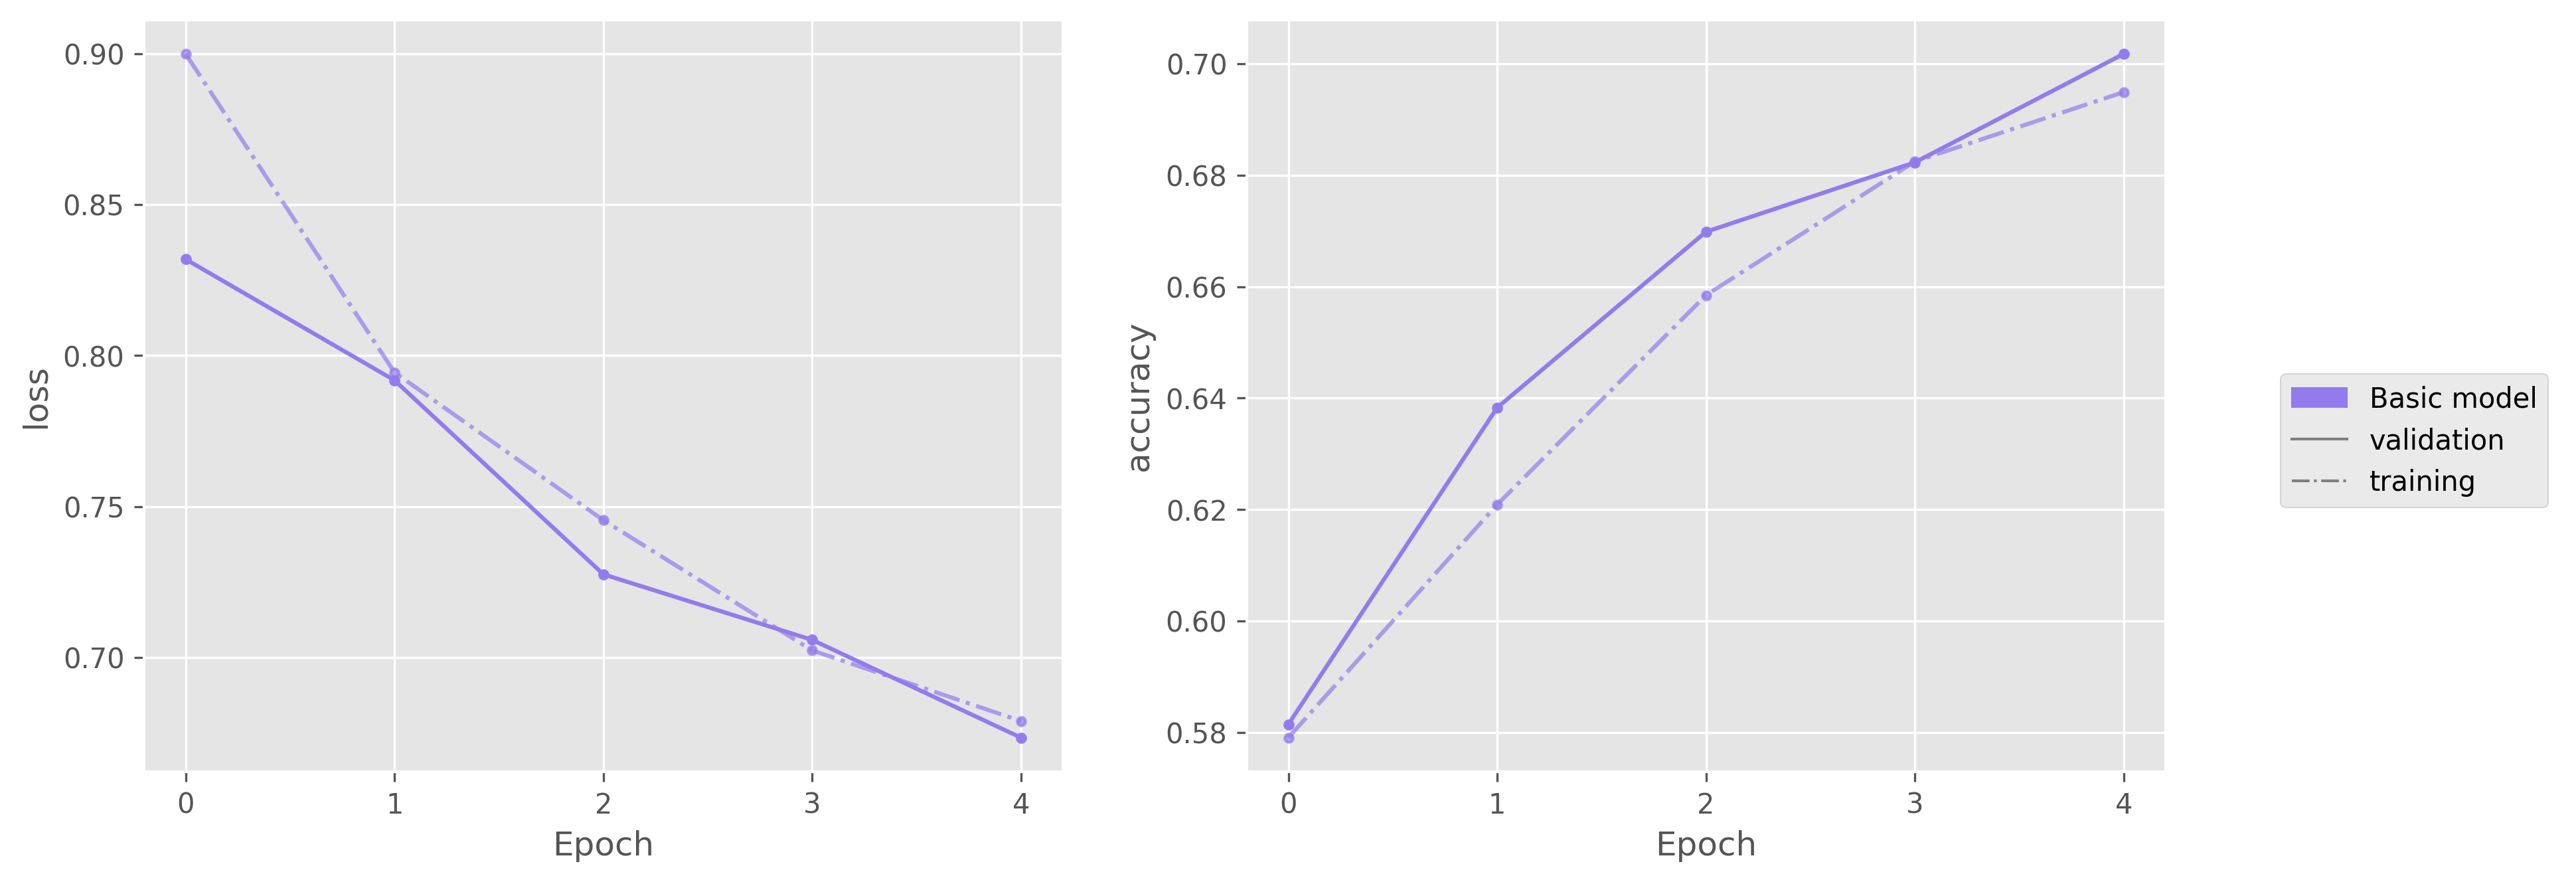

In [15]:
#for image, mask in test_dataset.take(3):
#    pred_mask = UNet_model.predict(image)
#    display([image[0], mask[0], create_mask(pred_mask)])

get_models_history(training_histories)